##  Feature Selection ##

Steps:

1. Import important libraraies.


In [8]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

2. Use Feature Importance (Random Forest / XGBoost feature importance scores) to rank variables.

In [9]:
top_features_df = pd.read_csv("../data/heart_disease.csv")

X = top_features_df.drop('num', axis=1)
y = top_features_df['num']

rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X, y)

importance = pd.Series(rf.feature_importances_, index=X.columns)

importance = importance.sort_values(ascending=False)
print(importance)

thalach      0.145329
oldpeak      0.128528
cp_4         0.121866
thal_7       0.106163
age          0.102276
chol         0.093677
trestbps     0.087934
exang        0.058758
slope_2      0.041345
sex          0.038038
ca_1         0.032284
cp_3         0.022391
restecg_2    0.021411
dtype: float64


3. Visualize feature importance

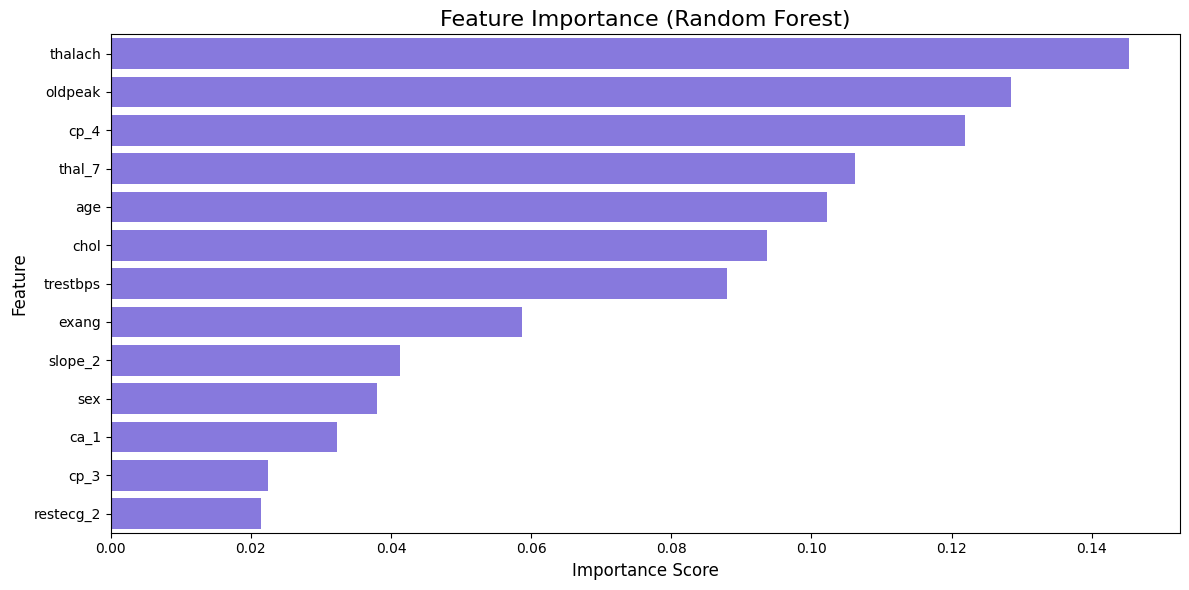

In [10]:
plt.figure(figsize=(12,6))
sns.barplot(x=importance.values, y=importance.index, color="mediumslateblue")
plt.title("Feature Importance (Random Forest)", fontsize=16)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

4. Apply Recursive Feature Elimination (RFE) to select the best predictors.

In [11]:
rfe = RFE(estimator=rf, n_features_to_select=8)
rfe.fit(X, y)

selected_features_mask = rfe.support_

selected_features = X.columns[selected_features_mask]
print("Selected features by RFE:", selected_features.tolist())

Selected features by RFE: ['thalach', 'oldpeak', 'age', 'trestbps', 'chol', 'cp_4', 'exang', 'thal_7']


5. Use Chi-Square Test to check feature significance.

In [12]:
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

chi_scores, p_values = chi2(X_scaled, y)

chi_results = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Score': chi_scores,
    'p-value': p_values
}).sort_values(by='Chi2 Score', ascending=False)

print(chi_results)

      Feature  Chi2 Score       p-value
7      thal_7   42.958360  5.591745e-11
5        cp_4   42.410097  7.400700e-11
6       exang   38.052613  6.886243e-10
9        cp_3   21.551109  3.445235e-06
8     slope_2   20.624160  5.588639e-06
12       ca_1   12.461167  4.155004e-04
1     oldpeak   11.382669  7.413251e-04
10        sex    7.432845  6.404399e-03
11  restecg_2    3.987845  4.582964e-02
0     thalach    2.670638  1.022151e-01
2         age    1.005896  3.158880e-01
3    trestbps    0.532647  4.654960e-01
4        chol    0.111079  7.389193e-01


6. Visual summary of the three feature selection methods.

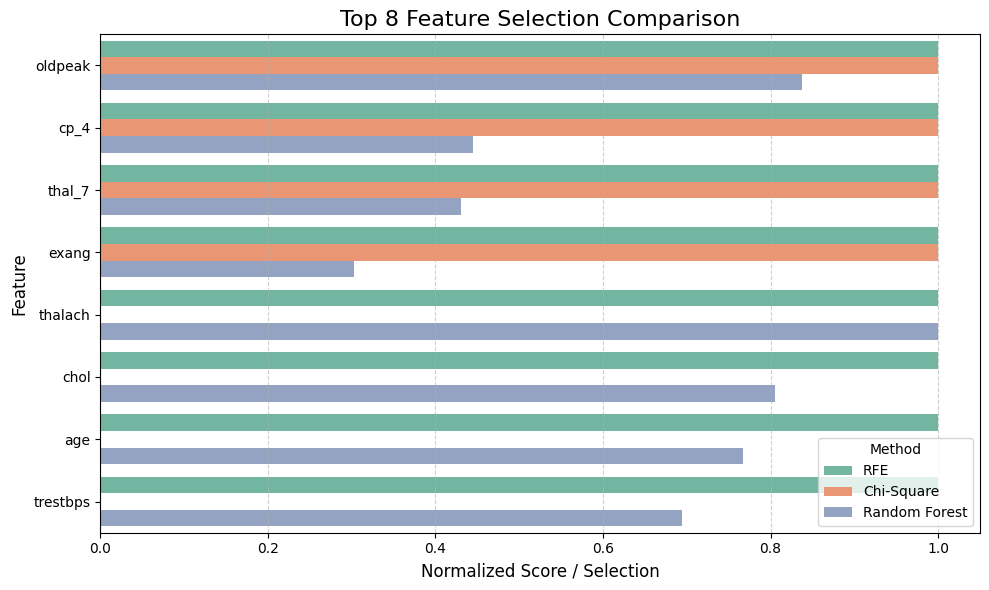

In [13]:
features = ['thalach','oldpeak','chol','age','trestbps','cp_4','exang','thal_7', 'slope_2','cp_3','ca_1','sex','restecg_2']

# RFE (1 = selected, 0 = not selected)
rfe = np.array([1 , 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

# Chi-Square (1 for p < 0.05, 0 for p >= 0.05)
chi2_sig = np.array([0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0])


# Random Forest Importance (scaled 0–1 for visualization)
rf_importance = np.array([0.159933, 0.133937, 0.128845, 0.122684, 0.111063, 0.071179, 0.048507, 0.068856, 0.036100, 0.017493, 0.038873, 0.033186, 0.029345])

rf_norm = rf_importance / rf_importance.max()

df_vis = pd.DataFrame({
    'Feature': features,
    'RFE': rfe,
    'Chi-Square': chi2_sig,
    'Random Forest': rf_norm
})

df_vis['Mean'] = df_vis[['RFE','Chi-Square','Random Forest']].mean(axis=1)
df_vis = df_vis.sort_values('Mean', ascending=False).head(8)

df_melt = df_vis.melt(id_vars='Feature', value_vars=['RFE','Chi-Square','Random Forest'], var_name='Method', value_name='Score')

plt.figure(figsize=(10,6))
sns.barplot(x='Score', y='Feature', hue='Method', data=df_melt, palette='Set2')
plt.title('Top 8 Feature Selection Comparison', fontsize=16)
plt.xlabel('Normalized Score / Selection', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xlim(0,1.05)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.legend(title='Method')
plt.tight_layout()
plt.show()


7. Save the changes

In [14]:
selected_features = ['oldpeak', 'cp_4', 'thal_7', 'exang', 'thalach', 'chol','age', 'trestbps', 'num']
df_filtered = top_features_df[selected_features]
df_filtered.to_csv("../data/heart_disease.csv", index=False)